In [2]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2 
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

In [3]:
# set pandas options 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# csv repo
data_source = 'data_csv'

# establish URL for connection to the database 
url_object = URL.create(
    'postgresql+psycopg2',
    username='postgres',
    password='Ee123456!',
    host='localhost',
    database='Masters:Programing_with_python',
)

# set matplotlib style
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
data_source = 'data_csv'

__margin = np.sqrt(2)

### probably will be some class properties

In [81]:
class CSVReadErr(Exception):
    def __init__(self, message='Error reading CSV file'):
        self.message = message
        super().__init__(self.message)

class DimMismatchErr(Exception):
    def __init__(self, train_dim, ideal_dim, message='Mismatch in dimensions between ideal and training data:'):
        self.message = '\n'.join([message, f'Amout of train points {train_dim}', f'Amout of ideal points {ideal_dim}'])
        super().__init__(self.message)

class MissPointsErr(Exception):
    def __init__(self, message='Some points missing, features(x) are not equal'):
        self.message = message
        super().__init__(self.message)


In [106]:
class Colors:
    def __init__(self):
        self.__color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        self.current_index = 0
        
    @property
    def next_color(self):
        color = self.__color_cycle[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.__color_cycle)
        return color
    
    @property
    def reset(self):
        self.current_index = 0


class CSVToDataBase:
    def __init__(self, csv_name, csv_source, db_name, db_url):
        self.csv_name = csv_name
        self.db_name = db_name
        self.url = db_url
        self.csv_source = csv_source
        self.col_names = list()
        
    @property
    def rename_columns(self, col_names):
        self.col_names = col_names    

    def _create_table(self, engine):
        df = pd.read_csv(os.path.join(self.csv_source, self.csv_name))
        if self.col_names:
            df.columns = self.col_names           
        df.to_sql(self.db_name, engine, if_exists='replace', index=False)

    def create(self):
        engine = create_engine(self.url, pool_pre_ping=True)
        self._create_table(engine)
        print(f'Database "{self.db_name}" was created!')


class CustomDF(pd.DataFrame):
    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)
    
    @property
    def _constructor(self):
        return CustomDF
    
    @classmethod
    def read_sql_query(cls, query, url, *args, **kwargs):
        """
        Read SQL query into a CustomDF object.
        Returns a table of data corresponding to the result of the query string.
        
        Parameters
        ----------
        query: str; SQL query to be executed.
        url: sqlalchemy.engine.URL object /..add../
        
        Returns
        -------
        Returns a CustomDF object that contains the result set of the
        executed SQL query, in relation to the specified database connection.
        """
        engine = create_engine(url, pool_pre_ping=True)
        with engine.connect() as conn:
            return pd.read_sql_query(text(query), con=conn, *args, **kwargs) 
    
    @classmethod 
    def read_by_lines(cls, file_name, data_source):
        """
        Read CSV file line by line into a CustomDF object.
        
        Parameters
        ----------
        file_name: str
            Name of the CSV file.
        data_source: str | os.path object, optional
            Corresponding to the path to the directory with CSV files.
        
        Returns
        -------
        CustomDF
            A custom DataFrame object containing the result set of the data from the CSV file.
        """
        try:
            file_path = os.path.join(data_source, file_name)
            rows = []
            
            # read CSV file line by line
            with open(file_path, 'r') as file:
                columns = file.readline().strip().split(',')
                # init CustomDF object 
                df = cls(columns=columns)
                
                # iter trought lines
                for line in file:
                    values = line.strip().split(',')
                    rows.append(values)
                
                # add file data to CustomDF object    
                df = pd.concat([df, CustomDF(rows, columns=df.columns)], ignore_index=True)
                # change dtypes to numeric
                df = df.astype(float)
            return df

        except Exception as e:
            raise CSVReadErr(f'Error reading CSV file: {str(e)}')
            
    @classmethod 
    def mean_square_error(cls, ideal, train):
        
        # check features
        if not (ideal.columns == 'X').any() or not (train.columns == 'X').any():
            raise IndexError('Feature "X" has not been found')
        # check matching dimentions
        if not train.shape[0] == ideal.shape[0]:
            raise DimMismatchErr(train.shape[0], ideal.shape[0])
        # check missing points
        if not (ideal['X'] == train['X']).all():
            raise MissPointsErr()
        
        # sort before computing    
        ideal = ideal.sort_values(by='X')
        train = train.sort_values(by='X')
        
        features = train['X']
        train_lables = train.drop(columns=['X'])
        
        ideal_lables = ideal.drop(columns=['X'])
        
        MSE = cls()
        
        for (train_name, train_lable) in train_lables.iteritems():
            frame = cls._sq_err_matrix(ideal_lables, train_lable)
            frame.loc['sum'] = frame.sum()
            MSE[train_name] = frame.loc['sum'] / features.shape[0]
            
        MSE.index = [idx.split('_')[-1] for idx in MSE.index]
        MSE.index.name = 'No ideal func'
        
        return MSE
    
    @classmethod
    def _sq_err_matrix(cls, ideal_lables, train_col):
        sq_err_matrix = cls().from_dict({'reference': train_col})
        for (ideal_name, ideal_lable) in ideal_lables.iteritems():
            sq_err_matrix[f'sq_dif_{ideal_name}'] = np.power((sq_err_matrix['reference'] - ideal_lable), 2)
        return sq_err_matrix.drop(columns=['reference'])
    
    def bar_plot():
        pass


# Converting and Load data
## First will create databases 
According to the task:  Your Python program needs to be able to
independently compile a SQLite database (file) ideally via sqlalchemy and load the training data into a single fivecolumn spreadsheet/table in the file. Its first column depicts the x-values of all functions. The fifty ideal functions, which are also
provided via a CSV-file, must be loaded into another table. Likewise, the first column depicts the x-values,
meaning there will be 51 columns overall. 

In [96]:
db_creator = CSVToDataBase('train.csv', data_source, 'The training data', url_object)
db_creator.rename_columns = ['X'] + [f'Y{i}(training func)' for i in range(1, 5)]
db_creator.create()

Database "The training data" was created!


In [6]:
db_creator = CSVToDataBase('ideal.csv', data_source, 'The ideal functions', url_object)
db_creator.rename_columns = ['X'] + [f'Y{i}(ideal func)' for i in range(1, 51)])
db_creator.create()

Database "The ideal functions" was created!


## Read train and ideal from database

In [92]:
train = CustomDF.read_sql_query('SELECT * FROM "The training data"', url_object)
ideal = CustomDF.read_sql_query('SELECT * FROM "The ideal functions"', url_object)

## Read test data from csv file line by line

In [63]:
test = CustomDF.read_by_lines('test.csv', data_source)

# MSE

In [111]:
mse = CustomDF.mean_square_error(ideal, train)
mse.head()

,Y1(training func),Y2(training func),Y3(training func),Y4(training func)
No ideal func,,,,
Y1(ideal func),531.472176,534.268865,134.514539,0.552048
Y2(ideal func),532.346369,533.420559,133.876070,0.614010
Y3(ideal func),629.273209,636.107997,235.501458,100.253745
Y4(ideal func),556.725800,559.819042,159.848446,25.943774
Y5(ideal func),636.494906,630.439191,232.010051,100.850119


In [62]:
(test['x'].isin(ideal['X'])).all() # test case 

True

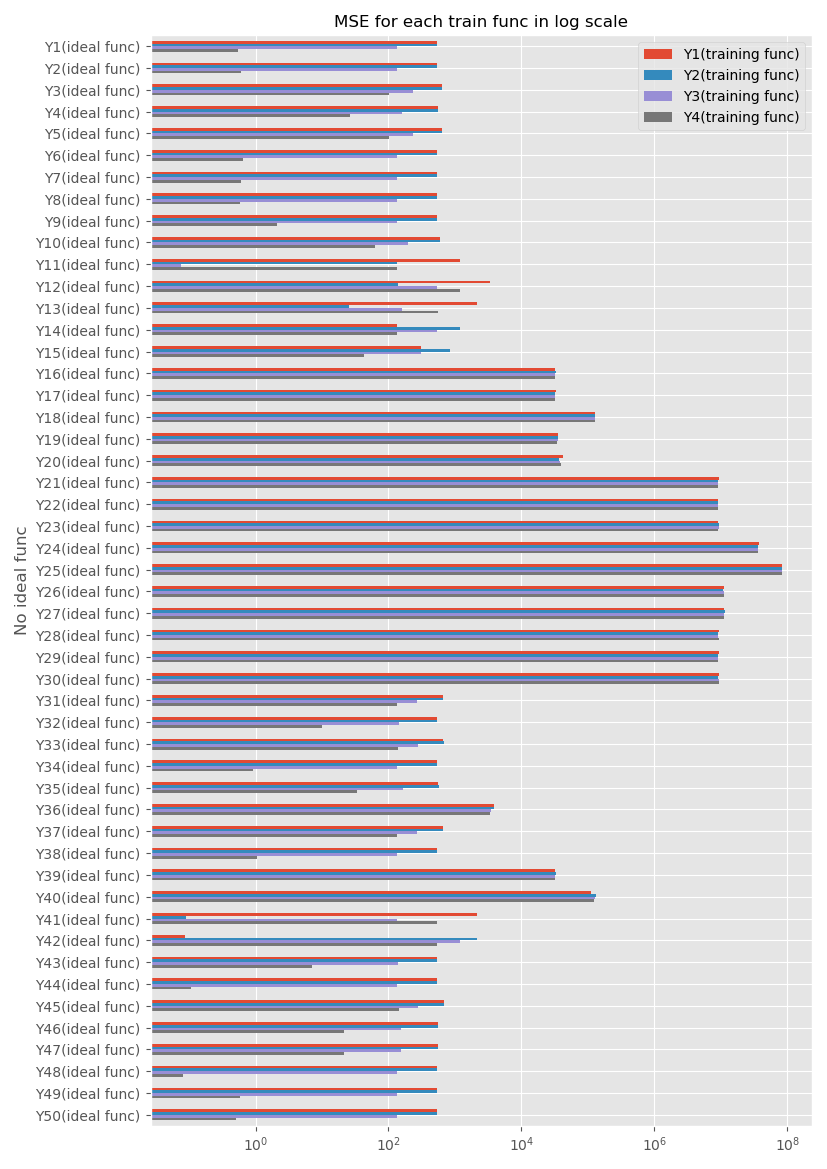

In [115]:
# ploting MSE
ax = mse.plot(
    figsize=(8.27, 11.69),
    kind='barh', 
    logx=True,
    fontsize=10,
)
ax.set_title('MSE for each train func in log scale', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()

In [21]:
best_fit = pd.DataFrame(
    {
        'No. of ideal func': MSE.iloc[MSE.agg(np.argmin)].index,
        'MSE': MSE.agg(np.min)
    }
).transpose()

best_fit

,train_y1,train_y2,train_y3,train_y4
No. of ideal func,y42,y41,y11,y48
MSE,0.085616,0.089005,0.074655,0.079909


In [22]:
chosen_ideal = best_fit.loc['No. of ideal func'].to_list()
chosen_ideal

['y42', 'y41', 'y11', 'y48']

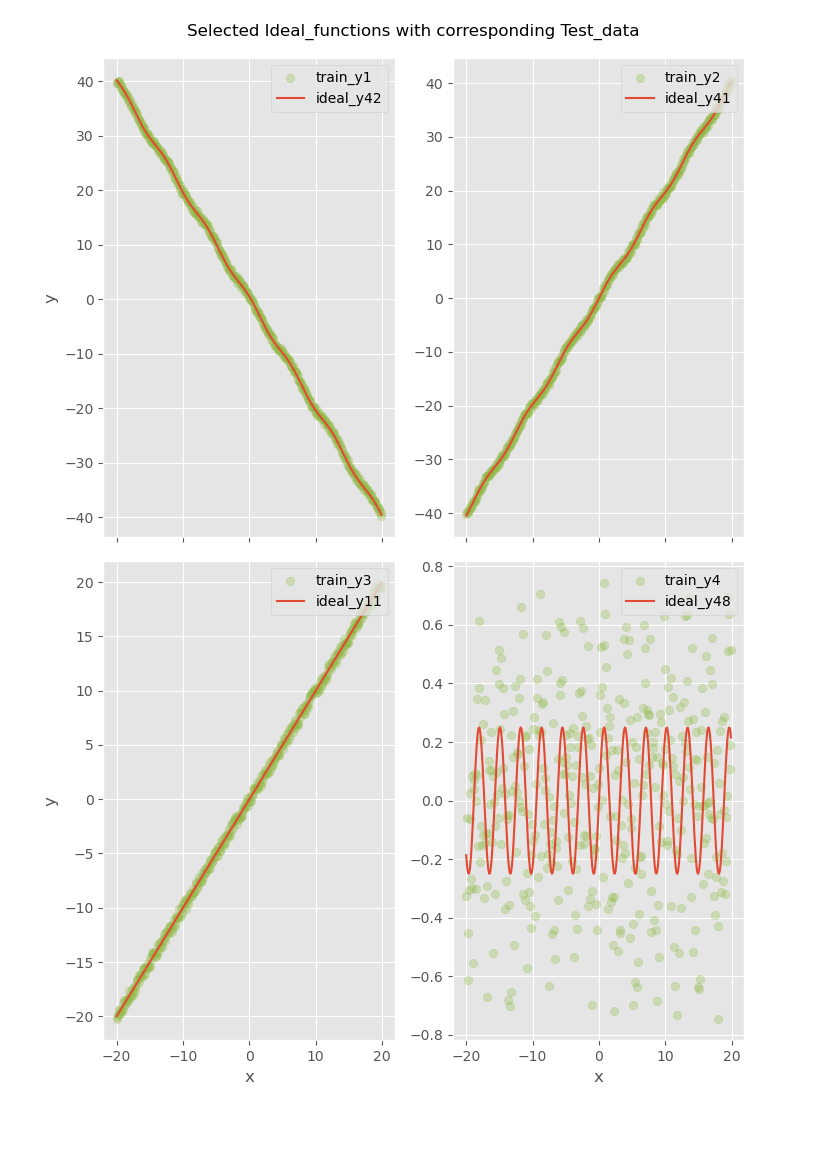

In [77]:
# # create graphs fitting ideal to train *4
x = train['x']

def plot_test_to_ideal(ideal_chosen, train):
    fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(8.27, 11.69), sharex=True)
    axis = fig.get_axes()
    color = Colors()
    
    plt.subplots_adjust(hspace=0.05, top=0.95) 
    fig.suptitle('Selected Ideal_functions with corresponding Test_data')
    
    # set lables
    for idx, ax in enumerate(axis):
        if idx>1:
            ax.set(xlabel='x')
        if idx%2==0:
            ax.set(ylabel='y')
            
    # plot graphs
    for ax, (train_name, train_data), (ideal_name, ideal_data) in zip(axis, train.iteritems(), ideal_chosen.iteritems()):
        ax.scatter(x=x, y=train_data, alpha=0.3, c='C5')
        ax.plot(x, ideal_data, c=color.next_color)
        ax.legend([f'train_{train_name}', f'ideal_{ideal_name}'], loc='upper right')
        
plot_test_to_ideal(ideal_chosen=ideal[chosen_ideal], train=train_lables)

In [24]:
merged_df = pd.merge(
    left=test.sort_values(by='x'),
    right=ideal[chosen_ideal + ['x']],
    how='left',
    on='x',
)
merged_df.head()

,x,y,y42,y41,y11,y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051


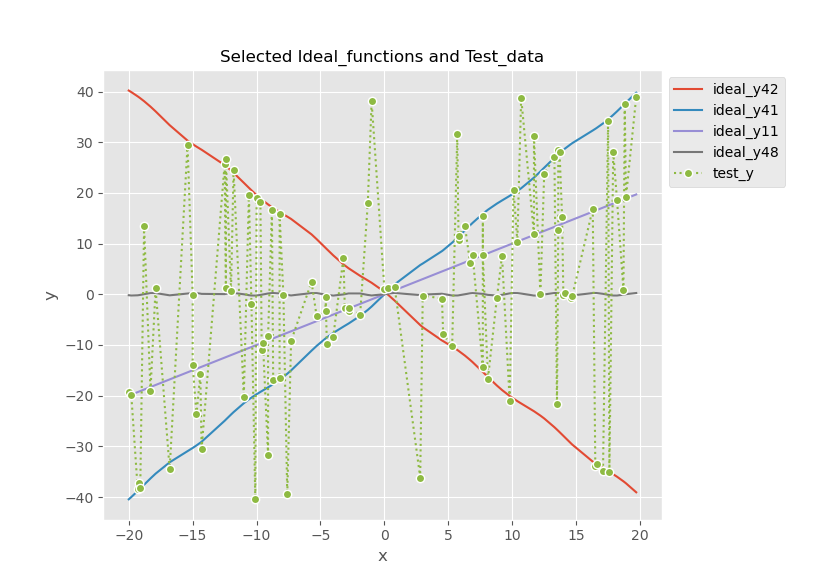

In [25]:
ax2 = merged_df.plot(x='x', 
                     y=chosen_ideal, 
                     ylabel='y', 
                     figsize=(8.27, 5.84)
                    )
ax2.set_title('Selected Ideal_functions and Test_data', fontsize=12)
ax2.plot(merged_df['x'], merged_df['y'], 'C5o:', mec='1.0')
labels = [f'ideal_{ch_i}' for ch_i in chosen_ideal] + ['test_y']
plt.subplots_adjust(right=0.8)
ax2.legend(labels=labels, loc='upper left', bbox_to_anchor=(1, 1))

In [26]:
ans = pd.Series(dtype=np.int32,
                name='amount of fitted points', 
                index=pd.Index([], name='ideal_func')
               )

for ideal_func in chosen_ideal:
    merged_df[f'div_{ideal_func}'] = np.absolute(merged_df['y'] - merged_df[ideal_func])
    ans[ideal_func] = sum(merged_df[f'div_{ideal_func}'] < __margin)
    
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


In [27]:
ans.to_frame().transpose()

ideal_func,y42,y41,y11,y48
amount of fitted points,21,26,26,18


# Creating CustomDF for final db

In [28]:
# final df init
test_mapped = pd.DataFrame(columns=['X (test func)', 'Y (test func)', 'Delta Y (test func)', 'No. of ideal func'])
idx = 0
nest_in_list = True #param

for i, row in merged_df.iterrows():
    # init row that will be implicted in df
    row_test_data = [row['x'].round(2), row['y']] # 1st and 2nd columns
    delta, No = list(), list() # 3rd and 4th columns
    
    for ideal_func_No, div in zip(chosen_ideal, row[chosen_ideal]):
        if abs(div - row['y']) < __margin:
            delta.append(round(abs(div - row['y']),6))
            No.append(ideal_func_No)
    # missing values case
    if not delta:
        delta = [pd.NA]
        No = [pd.NA]
    
    
    if nest_in_list:
        # covering into list multiple values
        if len(delta) > 1:
            delta = [delta]
            No = [No]
        test_mapped.loc[i] = row_test_data + delta + No
    else:
        # duplicate row with multiple fitting ideal_func datapoints
        for d, N in zip(delta, No):
            test_mapped.loc[idx] = row_test_data + [d, N]
            idx+=1

In [30]:
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


# Playing with inheritance from pd.df